In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
import numpy as np
import glob
import h5py
import fsspec
import math
from scipy import signal
from pyproj import Proj, CRS
import matplotlib.pyplot as plt
import shapely.wkt as wkt
import rasterio
from rasterio.crs import CRS
from rasterio.transform import from_origin
from rasterio import merge
import folium
from folium import plugins
import rioxarray
import matplotlib as mpl
import sys

import warnings
warnings.filterwarnings('ignore')

#### SJV

In [35]:
sys.path.append('../../')
from src.cslc_utils import read_cslc, cslc_info, rasterWrite, custom_merge, colorize, getbasemaps, moving_window_mean

In [36]:
path_1 = '/u/trappist-r0/kdevlin/work/CSLC/Tulare/D144/stack/t144_308014_iw2/t144_308014_iw2/20170601/t144_308014_iw2_20170601.h5'
path_2 = '/u/trappist-r0/kdevlin/work/CSLC/Tulare/D144/stack/t144_308014_iw2/t144_308014_iw2/20170613/t144_308014_iw2_20170613.h5'

In [37]:
#data_dir = 's3://opera-pst-rs-pop1/products/cslc_historical_20190701_to_20190718/' #ALH chng
burst_id = ['t144_308014_iw2'] #ALH chng
#burst_id = ['t071_151217_iw2', 't071_151218_iw2']  #Test for at least 2 burst_ids
date = ['20170601', '20170613'] #ALH chng
save_fn = f'TEST_{date[1]}-{date[0]}_{burst_id[0][:4]}.tif'

In [45]:
# Read before and after event dataset 
before = []; after = []  

for id in burst_id:
    path_h5 = path_1 #ALH chng
    # path_h5 = f'{data_dir}/{id}/{date[0]}/{id}_{date[0]}.h5' 

    dat = read_cslc(path_h5)
    before.append(dat)

for id in burst_id:
    path_h5 = path_2 #ALH chng
    # path_h5 = f'{data_dir}/{id}/{date[1]}/{id}_{date[1]}.h5' 
    dat = read_cslc(path_h5)
    after.append(dat)

Opening: /u/trappist-r0/kdevlin/work/CSLC/Tulare/D144/stack/t144_308014_iw2/t144_308014_iw2/20170601/t144_308014_iw2_20170601.h5
Opening: /u/trappist-r0/kdevlin/work/CSLC/Tulare/D144/stack/t144_308014_iw2/t144_308014_iw2/20170613/t144_308014_iw2_20170613.h5


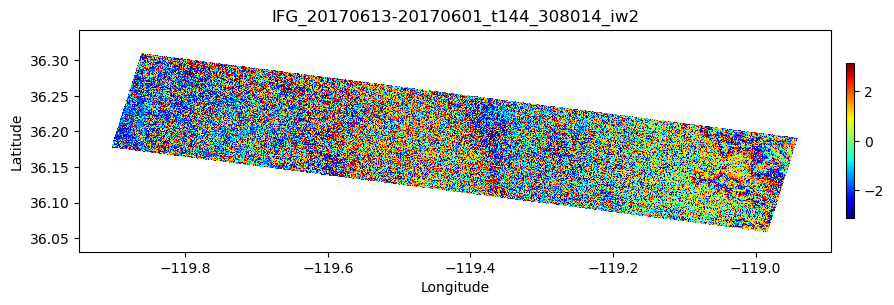

In [39]:
%matplotlib inline

for i, id in enumerate(burst_id):
    # xcoor, ycoor, dx, dy, epsg, bounding_polygon, orbit_direction = cslc_info(f'{data_dir}/{id}/{date[0]}/{id}_{date[0]}.h5')
    xcoor, ycoor, dx, dy, epsg, bounding_polygon, orbit_direction = cslc_info(path_1) #ALH chng

    cslc_poly = wkt.loads(bounding_polygon)
    bbox = [cslc_poly.bounds[0], cslc_poly.bounds[2], cslc_poly.bounds[1], cslc_poly.bounds[3]]

    # Calculate burst-wise interferogram
    ifg = after[i] * np.conj(before[i])
    
    # Plot each interferogram
    fig, ax = plt.subplots(figsize=(10,3))
    cax = ax.imshow(colorize(np.angle(ifg), 'jet', -np.pi, np.pi), cmap='jet',interpolation='nearest', origin='upper',extent=bbox, vmin=-np.pi, vmax=np.pi)
    plt.colorbar(cax,orientation='vertical',fraction=0.01,pad=0.02)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'IFG_{date[1]}-{date[0]}_{id}',fontsize=12)

    # Save each interferogram as GeoTiff
    transform = from_origin(xcoor[0],ycoor[0],dx,np.abs(dy))
    rasterWrite(f'ifg_{id}.tif',np.angle(ifg),transform,epsg,dtype=rasterio.float32)
    
after = []; before=[]

In [40]:
# Merge geotiff files with rasterio
ifg_files = [(f'ifg_{id}.tif') for id in burst_id]
ifg_files_to_mosaic = []

for f in ifg_files:
    src = rasterio.open(f)
    ifg_files_to_mosaic.append(src)

dest, output_transform=merge.merge(ifg_files_to_mosaic, method=custom_merge)
with rasterio.open(ifg_files[0]) as src:
        out_meta = src.meta.copy() 
out_meta.update({"driver": "GTiff",
                 "height": dest.shape[1],
                 "width": dest.shape[2],
                 "transform": output_transform})
with rasterio.open(save_fn, "w", **out_meta) as dest1:
        dest1.write(dest)
        dest1.close()

# print(dest.shape)

In [41]:
# Read the merged raster file
src = rioxarray.open_rasterio(save_fn)
merged_ifg = src.rio.reproject("EPSG:4326")[0]             # Folium maps are in EPSG:4326
minlon,minlat,maxlon,maxlat = merged_ifg.rio.bounds()

# Downsample for folium visualization and attach RGBA color to numpy array
colored_merged_ifg = colorize(merged_ifg[::6][::6], 'jet', -np.pi, np.pi)

# Define new bounding box
new_bbox = [minlon,maxlon,minlat,maxlat]

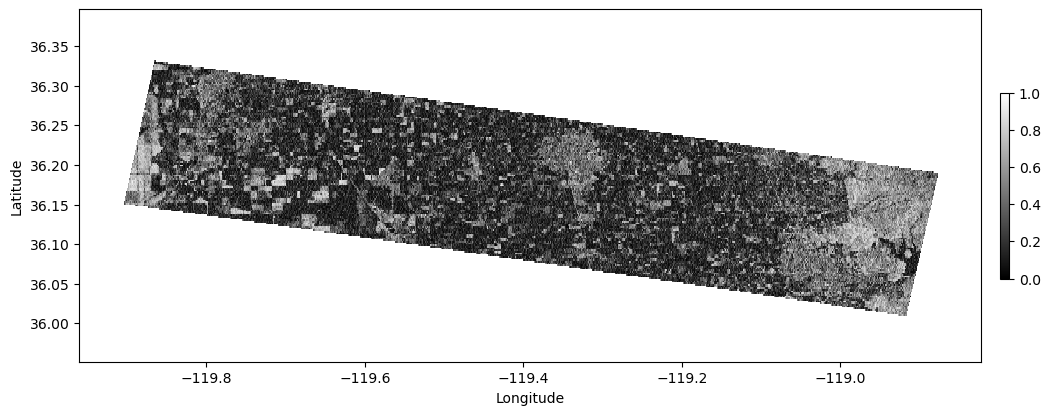

In [42]:
# Calculate the correlation/coherence
merged_ifg_cpx = np.exp(1j * np.nan_to_num(merged_ifg))
integral_img, window_mean = moving_window_mean(merged_ifg_cpx, 10)
coh = np.clip(np.abs(window_mean), 0, 1)

# Mask nan values and zero values based on merged ifg file
nan_mask = np.isnan(merged_ifg)
zero_mask = merged_ifg == 0
coh[nan_mask] = np.nan
coh[zero_mask] = 0

# Downsample for folium visualization and attach RGBA color to numpy array
colored_coh = colorize(coh[::6][::6], 'gray', 0., 1)

# Plot
fig, ax = plt.subplots(figsize=(12,9))
cax = ax.imshow(colored_coh, cmap='gray',interpolation='nearest', origin='upper',extent=new_bbox, vmin=0, vmax=1.)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
#ax.set_title(f'COH_{date[1]}-{date[0]}_{orbit_direction}_{burst_id[0][:4]}',fontsize=12)
fig.colorbar(cax,orientation='vertical',fraction=0.01,pad=0.02)
plt.show()

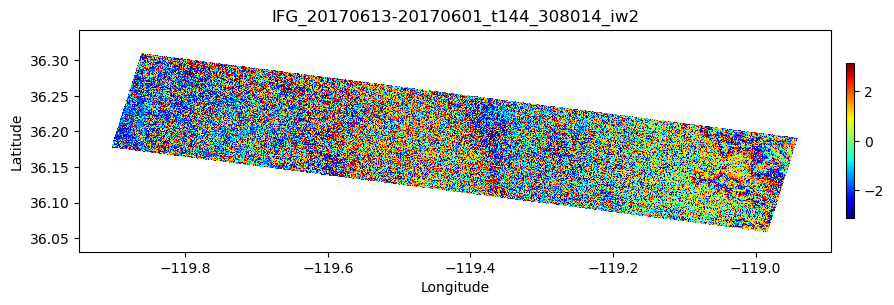

In [46]:
%matplotlib inline

for i, id in enumerate(burst_id):
    # xcoor, ycoor, dx, dy, epsg, bounding_polygon, orbit_direction = cslc_info(f'{data_dir}/{id}/{date[0]}/{id}_{date[0]}.h5')
    xcoor, ycoor, dx, dy, epsg, bounding_polygon, orbit_direction = cslc_info(path_1) #ALH chng

    cslc_poly = wkt.loads(bounding_polygon)
    bbox = [cslc_poly.bounds[0], cslc_poly.bounds[2], cslc_poly.bounds[1], cslc_poly.bounds[3]]

    # Calculate burst-wise interferogram
    pow1 = before[0] * np.conj(before[0])
    pow2 = after[0] * np.conj(after[0])
    phase = np.angle(ifg / np.sqrt(pow1 * pow2 + 1e-7))
    
    # Plot each interferogram
    fig, ax = plt.subplots(figsize=(10,3))
    cax = ax.imshow(colorize(np.angle(ifg), 'jet', -np.pi, np.pi), cmap='jet',interpolation='nearest', origin='upper',extent=bbox, vmin=-np.pi, vmax=np.pi)
    plt.colorbar(cax,orientation='vertical',fraction=0.01,pad=0.02)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'IFG_{date[1]}-{date[0]}_{id}',fontsize=12)

    # Save each interferogram as GeoTiff
    transform = from_origin(xcoor[0],ycoor[0],dx,np.abs(dy))
    rasterWrite(f'ifg_{id}.tif',np.angle(ifg),transform,epsg,dtype=rasterio.float32)

In [47]:
# Merge geotiff files with rasterio
ifg_files = [(f'ifg_{id}.tif') for id in burst_id]
ifg_files_to_mosaic = []

for f in ifg_files:
    src = rasterio.open(f)
    ifg_files_to_mosaic.append(src)

dest, output_transform=merge.merge(ifg_files_to_mosaic, method=custom_merge)
with rasterio.open(ifg_files[0]) as src:
        out_meta = src.meta.copy() 
out_meta.update({"driver": "GTiff",
                 "height": dest.shape[1],
                 "width": dest.shape[2],
                 "transform": output_transform})
with rasterio.open(save_fn, "w", **out_meta) as dest1:
        dest1.write(dest)
        dest1.close()

# print(dest.shape)

In [48]:
# Read the merged raster file
src = rioxarray.open_rasterio(save_fn)
merged_ifg = src.rio.reproject("EPSG:4326")[0]             # Folium maps are in EPSG:4326
minlon,minlat,maxlon,maxlat = merged_ifg.rio.bounds()

# Downsample for folium visualization and attach RGBA color to numpy array
colored_merged_ifg = colorize(merged_ifg[::6][::6], 'jet', -np.pi, np.pi)

# Define new bounding box
new_bbox = [minlon,maxlon,minlat,maxlat]

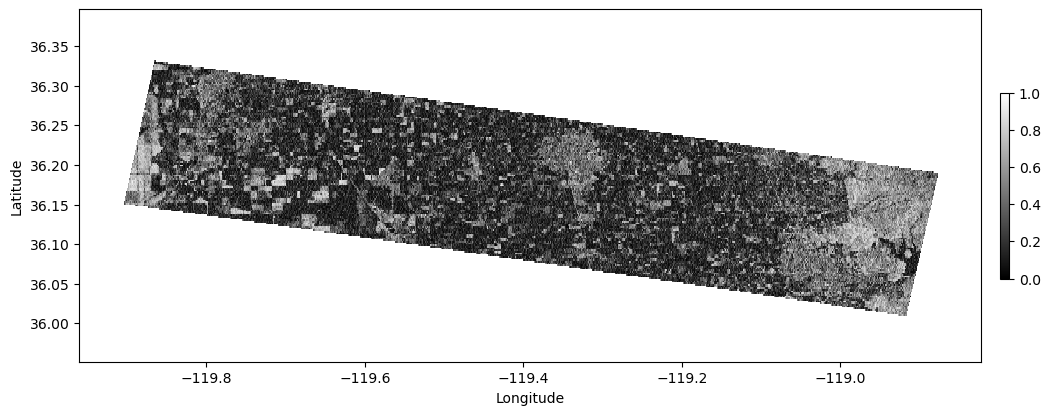

In [49]:
# Calculate the correlation/coherence
merged_ifg_cpx = np.exp(1j * np.nan_to_num(merged_ifg))
integral_img, window_mean = moving_window_mean(merged_ifg_cpx, 10)
coh2 = np.clip(np.abs(window_mean), 0, 1)

# Mask nan values and zero values based on merged ifg file
nan_mask = np.isnan(merged_ifg)
zero_mask = merged_ifg == 0
coh2[nan_mask] = np.nan
coh2[zero_mask] = 0

# Downsample for folium visualization and attach RGBA color to numpy array
colored_coh2 = colorize(coh2[::6][::6], 'gray', 0., 1)

# Plot
fig, ax = plt.subplots(figsize=(12,9))
cax = ax.imshow(colored_coh2, cmap='gray',interpolation='nearest', origin='upper',extent=new_bbox, vmin=0, vmax=1.)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
#ax.set_title(f'COH_{date[1]}-{date[0]}_{orbit_direction}_{burst_id[0][:4]}',fontsize=12)
fig.colorbar(cax,orientation='vertical',fraction=0.01,pad=0.02)
plt.show()


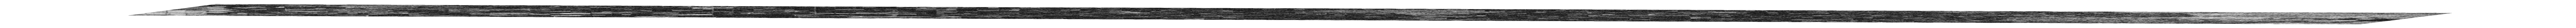
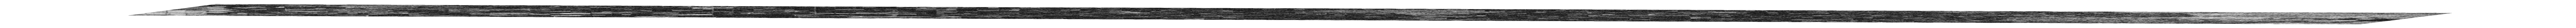

In [50]:
# Overlay merged bursts onto a basemap.
# Initialize Folium basemap and define center of mapview
xmid =(new_bbox[0]+new_bbox[1])/2 ; ymid = (new_bbox[2]+new_bbox[3])/2
m = folium.Map(location=[ymid, xmid], zoom_start=9, tiles='Stamen Terrain', show=True)

# Add custom basemaps
basemaps = getbasemaps()
for basemap in basemaps:
    basemaps[basemap].add_to(m)

# Overlay merged interferogram on a basemap
folium.raster_layers.ImageOverlay(colored_coh2, 
                                        opacity=1.0, 
                                        bounds=[[new_bbox[2],new_bbox[0]],[new_bbox[3],new_bbox[1]]],
                                        interactive=False,
                                        name='weighted Coherence',
                                        show=True).add_to(m)

# Include coherence as a layer
folium.raster_layers.ImageOverlay(colored_coh, 
                                        opacity=1.0, 
                                        bounds=[[new_bbox[2],new_bbox[0]],[new_bbox[3],new_bbox[1]]],
                                        interactive=False,
                                        name='Coherence',
                                        show=True).add_to(m)

# Include coherence as a layer
#folium.raster_layers.ImageOverlay(colored_coh_diff, 
                                        # opacity=1.0, 
                                        # bounds=[[new_bbox[2],new_bbox[0]],[new_bbox[3],new_bbox[1]]],
                                        # interactive=False,
                                        # name='Coherence Diff',
                                        # show=True).add_to(m)

#layer Control
m.add_child(folium.LayerControl())

# Add fullscreen button
plugins.Fullscreen().add_to(m)

#Add inset minimap image
minimap = plugins.MiniMap(width=300, height=300)
m.add_child(minimap)

#Mouse Position
fmtr = "function(num) {return L.Util.formatNum(num, 3) + ' º ';};"
plugins.MousePosition(position='bottomright', separator=' | ', prefix="Lat/Lon:",
                     lat_formatter=fmtr, lng_formatter=fmtr).add_to(m)

#Display
m